In [1]:
import os
import sys
import time
import sqlite3
from Functions.database import createTable
import tensorboard as tf

from envConfig import CONFIG
CONFIG["PACKAGE_NAME"] = os.path.join(CONFIG["OUTPUTDATAPATH"], "Classification")

import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

import seaborn as sns


analysis_name = 'Classification'

data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']


#db = sqlite3.connect(results_path+'classification.db')
#time = time.strftime("%a, %d %b %Y %H:%M:%S", time.gmtime())

In [2]:
from Functions.dataset.shipClasses import LoadData

dt_24 = LoadData(dev=False)
#dt_24.infoData()
all_data,all_trgt= dt_24.getData()

Using TensorFlow backend.


[+] Time to read data file: 3.87983894348 seconds


In [3]:
from Functions.preprocessing import CrossValidation

results_path_specific = results_path + '/dev' + '/Folds_HierNet/'
if not os.path.exists(results_path_specific):
    os.makedirs(results_path_specific)

cv = CrossValidation(X = all_data,y = all_trgt, estimator=None, n_folds=10, dev=True, verbose=1, dir=results_path_specific)



train_id, test_id, folder = cv.train_test_split(ifold=0)

File /home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/Folds_HierNet/10_folds_cross_validation_dev.jbl exists


In [4]:
from Functions.mlpClassification import MLPKeras
from Functions.preprocessing import CrossValidation,CVEnsemble
from Functions.ensemble import SpecialistClass,HierarqNet,HierarqClassification

import sklearn as sk



mlp = MLPKeras(hidden_layer_sizes=(10,),
                 activation=('tanh','tanh'),
                 optimize='adam',
                 lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False,
                 loss='mean_squared_error',
                 n_init=1,
                 batch_size=512,
                 epoch=1000,
                 shuffle=True,
                 random_state=None,
                 verbose=False,
                 train_log = True,
                 append=False,
                 class_weight = True,
                 early_stopping = True,
                 monitor='sp', min_delta=0, patience=25,
                 mode='max', baseline=None, restore_best_weights=True,
                 save_best_model = True,
                 save_weights_only=False,
                 metrics=['acc','sp'],
                 validation_id=(None,None),
                 validation_fraction=0.0,
                 dir='./')

classes={'class_S':[[9,10,13,14,16,23,1,2,22,21],
                             [4,6,8,12,17,19],
                             [11,24],
                             [5,7,15,3,18,20]],
        'class_A':[[9,10,13,14,16],
                        [23,1,2,22],
                        [21]],
        'class_B':[[4],
                        [6],
                        [8],
                        [12],
                        [17],
                        [19]],
        'class_D':[[5,7,15],
                [3,18,20]],
         
        'class_C':[[11],
                    [24]],
        'class_AA':[[9],
                         [10],
                         [13],
                         [14],
                         [16]],
        'class_AB':[[23],
                         [1],
                         [2],
                         [22]],
        'class_DA':[[5],
                         [7],
                         [15]],
        'class_DB':[[3],
                         [18],
                         [20]]}

map_lvl = {
    'class_S':0,
    'class_A':1,
    'class_AA':2,
    'class_AB':2,
    'class_AC':2,
    'class_B':1,
    'class_C':1,
    'class_D':1,
    'class_DA':2,
    'class_DB':2
}

hn = HierarqClassification(estimator=mlp,
                           dict_classes=classes,
                           map_members=map_lvl,
                           n_lvl=3,
                           file=results_path_specific,
                           load=False,verbose=True)

In [5]:
hn.fit(X=all_data, y=all_trgt, train_id=train_id, test_id=test_id, ifold=1)

fit member class_B
[+] 1 of 1 inits
[0 1 2 3 4 5]
[0 1 2 3 4 5]

[+]End Train - best epoch: 13 - best val score(sp): 0.950503
fit member class_S
[+] 1 of 1 inits
[0 1 2 3]
[0 1 2 3]

[+]End Train - best epoch: 4 - best val score(sp): 0.702759
fit member class_A
[+] 1 of 1 inits
[0 1 2]
[0 1 2]

[+]End Train - best epoch: 2 - best val score(sp): 0.789149
fit member class_AA
[+] 1 of 1 inits
[0 1 2 3 4]
[0 1 2 3 4]

[+]End Train - best epoch: 3 - best val score(sp): 0.889019
fit member class_D
[+] 1 of 1 inits
[0 1]
[0 1]

[+]End Train - best epoch: 1 - best val score(sp): 0.593935
fit member class_C
[+] 1 of 1 inits
[0 1]
[0 1]

[+]End Train - best epoch: 3 - best val score(sp): 0.701728
fit member class_DB
[+] 1 of 1 inits
[0 1 2]
[0 1 2]

[+]End Train - best epoch: 6 - best val score(sp): 0.657270
fit member class_DA
[+] 1 of 1 inits
[0 1 2]
[0 1 2]

[+]End Train - best epoch: 72 - best val score(sp): 0.907414
fit member class_AB
[+] 1 of 1 inits
[0 1 2 3]
[0 1 2 3]

[+]End Train - be

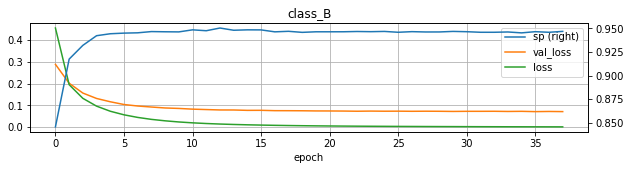

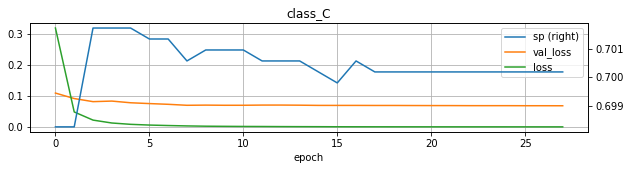

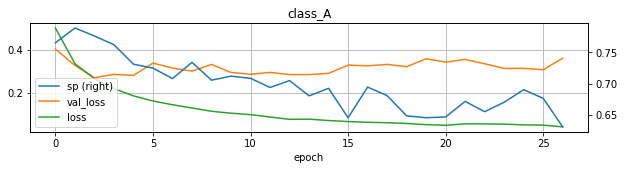

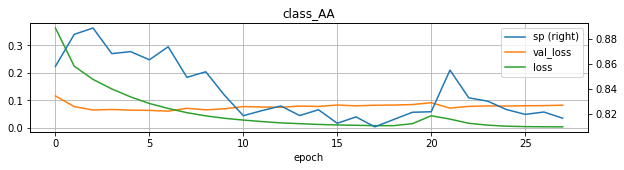

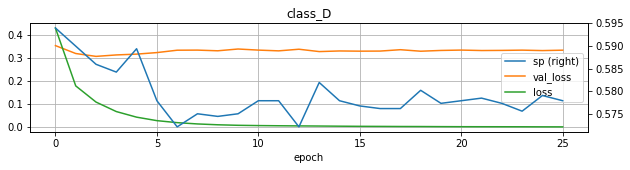

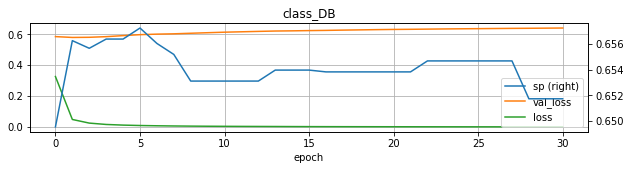

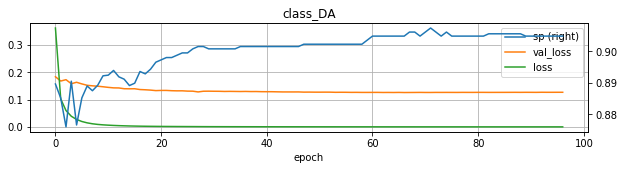

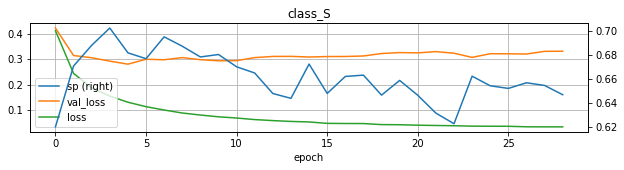

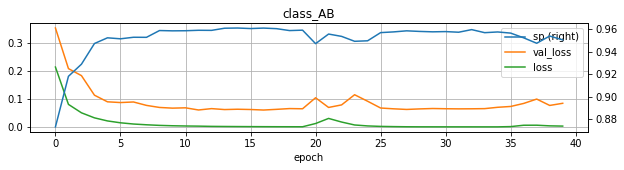

In [6]:
df_class = {}
for key,estimator in hn.estimators_.iteritems():
    df_class[key] = estimator.load_train()
    
df_ana = pd.concat(df_class)
for key in hn.estimators_.keys():
    plot = df_ana.loc[key].plot(x='epoch',y=['sp','val_loss','loss'],grid=True,figsize=(10,2),secondary_y=['sp'],title=key)
    fig = plot.get_figure()
    path_to_class = hn.estimators_[key].get_params()['dir']
    fig.savefig(path_to_class+"/log_train_sp_val_loss.png")

In [14]:
print hn.estimators_['class_A']._y_train.shape[0]
print hn.estimators_['class_A']._y_test.shape[0]
print(hn.estimators_['class_A']._y_test.shape[0] + hn.estimators_['class_A']._y_train.shape[0])

132499
14728
147227


In [8]:
hn.estimators_['class_A']._y.shape

(220163,)

In [6]:
#analysis of classifier S

_, _, y_new, ids = hn.estimators_['S']

ids = hn.estimators_['S'][-1]
index_per_class = np.array(range(all_trgt.shape[0]))
index = np.concatenate([index_per_class[ids[i]]for i in range(len(ids))])

df_index = pd.DataFrame({'index':index})

csv_anal = '/home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/HierNet/estimator_super/fold00/hierarq_analy_fold_0.csv'
hierarq_anal = pd.read_csv(csv_anal)
df_tabela_S = pd.concat([df_index,hierarq_anal],axis=1)
df_tabela_S.head()



,index,HierarqNet(resultados)_0,HierarqNet(valor)_0,fold_0,target_0
0,0,2,-0.461570,1,0
1,1,3,0.813823,1,0
2,2,3,0.714165,1,0
3,3,1,0.537195,1,0
4,4,1,0.469561,1,0


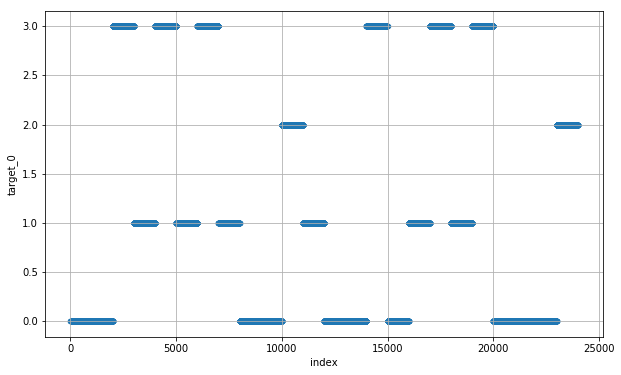

In [7]:


fig = plt.figure(figsize=(10,6))
ax = plt.subplot()
df_tabela_S.plot(x='index',y='target_0',kind='scatter',ax=ax)
#plt.xticks(range(5000))
ax.grid()

In [12]:
file = '/home/venancio/Workspace/SonarAnalysis/Results/Classification/Hierarq_withFolds_10_inits_10_folds_10_neurons_adam_optmizer_True_balanced_mapstd_norm_1000_epochs_512_batch_size_tanh_hidden_activation_tanh_output_activation_acc_sp_metric_mean_squared_error_loss/fold00/pred_all.csv'
df = pd.read_csv(file)

In [13]:
classes={'class_S':[[9,10,13,14,16,23,1,2,22,21],
                             [4,6,8,12,17,19],
                             [11,24],
                             [5,7,15,3,18,20]],
        'class_A':[[9,10,13,14,16],
                        [23,1,2,22],
                        [21]],
        'class_B':[[4],
                        [6],
                        [8],
                        [12],
                        [17],
                        [19]],
        'class_D':[[5,7,15],
                [3,18,20]],
         
        'class_C':[[11],
                    [24]],
        'class_AA':[[9],
                         [10],
                         [13],
                         [14],
                         [16]],
        'class_AB':[[23],
                         [1],
                         [2],
                         [22]],
        'class_DA':[[5],
                         [7],
                         [15]],
        'class_DB':[[3],
                         [18],
                         [20]]}

In [14]:

def pred_table(df,classes):
    for oldclass,newclass in enumerate(classes['class_AA']):
        newclass = map(lambda x:x-1,newclass)
        ix = df[(df['class_S']==0)&(df['class_A']==0)&(df['class_AA']==oldclass)]['pred'].index.values
        df.loc[ix,'pred'] = newclass

    return df
    for oldclass,newclass in enumerate(classes['class_AB']):
        newclass = map(lambda x:x-1,newclass)
        ix = df[(df['class_S']==0)&(df['class_A']==1)&(df['class_AB']==oldclass)]['pred'].index.values
        df.loc[ix,'pred'] = newclass

    #predict of class 21 (AC)
    ix = df[(df['class_S']==0)&(df['class_A']==2)]['pred'].index.values
    df.loc[ix,'pred'] = 20

    for oldclass,newclass in enumerate(classes['class_B']):
        newclass = map(lambda x:x-1,newclass)
        ix = df[(df['class_S']==1)&(df['class_B']==oldclass)]['pred'].index.values
        df.loc[ix,'pred'] = newclass

    for oldclass,newclass in enumerate(classes['class_C']):
        newclass = map(lambda x:x-1,newclass)
        ix = df[(df['class_S']==2)&(df['class_C']==oldclass)]['pred'].index.values
        df.loc[ix,'pred'] = newclass

    for oldclass,newclass in enumerate(classes['class_DA']):
        newclass = map(lambda x:x-1,newclass)
        ix = df[(df['class_S']==3)&(df['class_D']==0)&(df['class_DA']==oldclass)]['pred'].index.values
        df.loc[ix,'pred'] = newclass    

    for oldclass,newclass in enumerate(classes['class_DB']):
        newclass = map(lambda x:x-1,newclass)
        ix = df[(df['class_S']==3)&(df['class_D']==1)&(df['class_DB']==oldclass)]['pred'].index.values
        df.loc[ix,'pred'] = newclass    
    
    return df

In [15]:
df_new = pred_table(df,classes)


,class_A,class_AA,class_AB,class_B,class_C,class_D,class_DA,class_DB,class_S,pred
0,1,2,1,3,0,1,1,0,2,-1
1,1,2,1,3,0,0,1,0,3,-1
2,1,0,1,3,0,0,1,0,0,-1
3,1,2,1,3,0,0,1,0,2,-1
4,1,2,1,3,0,1,1,0,2,-1
5,1,1,1,3,0,1,1,0,3,-1
6,1,2,1,3,0,0,1,0,2,-1
7,1,2,1,3,0,0,1,0,0,-1
8,1,2,1,3,0,0,1,0,3,-1
9,1,2,1,3,0,1,1,0,3,-1
